In [ ]:
import os
import numpy as np
from transformers import AutoModelForTokenClassification, AutoTokenizer,DataCollatorForTokenClassification
from transformers import TrainingArguments, Trainer
import torch
import evaluate  # pip install evaluate
import seqeval   # pip install seqeval
from datasets import load_dataset
import torch.distributed as dist
import torch.multiprocessing as mp

# 设置分布式环境
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    dist.init_process_group("nccl", rank=rank, world_size=world_size)

# 清理分布式环境
def cleanup():
    dist.destroy_process_group()
    

def train(rank, world_size):
    setup(rank, world_size)
    # 数据集
    ds = load_dataset('nlhappy/CLUE-NER')
    # entity_index
    entites = ['O'] + list({'movie', 'name', 'game', 'address', 'position', \
               'company', 'scene', 'book', 'organization', 'government'})
    tags = ['O']
    for entity in entites[1:]:
        tags.append('B-' + entity.upper())
        tags.append('I-' + entity.upper())
    
    entity_index = {entity:i for i, entity in enumerate(entites)}

    tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-chinese')
    
    def entity_tags_proc(item):
        # item即是dataset中记录
        text_len = len(item['text'])  # 根据文本长度生成tags列表
        tags = [0] * text_len    # 初始值为‘O’
        # 遍历实体列表，所有实体类别标记填入tags
        entites = item['ents']
        for ent in entites:
            indices = ent['indices']  # 实体索引
            label = ent['label']   # 实体名
            tags[indices[0]] = entity_index[label] * 2 - 1
            for idx in indices[1:]:
                tags[idx] = entity_index[label] * 2
        return {'ent_tag': tags}
    
    # 使用自定义回调函数处理数据集记录
    ds1 = ds.map(entity_tags_proc)
    
    def data_input_proc(item):
        # 输入文本先拆分为字符，再转换为模型输入的token索引
        batch_texts = [list(text) for text in item['text']]
        # 导入拆分为字符的文本列表时，需要设置参数is_split_into_words=True
        input_data = tokenizer(batch_texts, truncation=True, add_special_tokens=False, max_length=512, 
                               is_split_into_words=True, padding='max_length')
        input_data['labels'] = [tag + [0] * (512 - len(tag)) for tag in item['ent_tag']]
        return input_data
        
    
    ds2 = ds1.map(data_input_proc, batched=True)  # batch_size 1000
    
    
    local_rank = rank
    
    id2lbl = {i:tag for i, tag in enumerate(tags)}
    lbl2id = {tag:i for i, tag in enumerate(tags)}
    
    model = AutoModelForTokenClassification.from_pretrained('google-bert/bert-base-chinese', 
                                                            num_labels=21,
                                                            id2label=id2lbl,
                                                            label2id=lbl2id)
    model.to(local_rank)
    
    args = TrainingArguments(
        output_dir="ner_train",  # 模型训练工作目录（tensorboard，临时模型存盘文件，日志）
        num_train_epochs = 3,    # 训练 epoch
        save_safetensors=False,  # 设置False保存文件可以通过torch.load加载
        per_device_train_batch_size=16,  # 训练批次
        per_device_eval_batch_size=16,
        report_to='tensorboard',  # 训练输出记录
        eval_strategy="epoch",
        local_rank=local_rank,   # 当前进程 RANK
        fp16=True,               # 使用混合精度
        lr_scheduler_type='linear',  # 动态学习率
        warmup_steps=100,        # 预热步数
        ddp_find_unused_parameters=False  # 优化DDP性能
    )
    
    def compute_metric(result):
        # result 是一个tuple (predicts, labels)
        
        # 获取评估对象
        seqeval = evaluate.load('seqeval')
        predicts,labels = result
        predicts = np.argmax(predicts, axis=2)
        
        # 准备评估数据
        predicts = [[tags[p] for p,l in zip(ps,ls) if l != -100]
                     for ps,ls in zip(predicts,labels)]
        labels = [[tags[l] for p,l in zip(ps,ls) if l != -100]
                     for ps,ls in zip(predicts,labels)]
        results = seqeval.compute(predictions=predicts, references=labels)
    
        return results
    
    data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, padding=True)
    
    trainer = Trainer(
        model,
        args,
        train_dataset=ds2['train'],
        eval_dataset=ds2['validation'],
        data_collator=data_collator,
        compute_metrics=compute_metric
    )
    
    trainer.train()

def main():
    world_size = torch.cuda.device_count()
    mp.spawn(train, args=(world_size,), nprocs=world_size, join=True)

if __name__ == "__main__":
    main()

/opt/miniconda3/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/py312/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


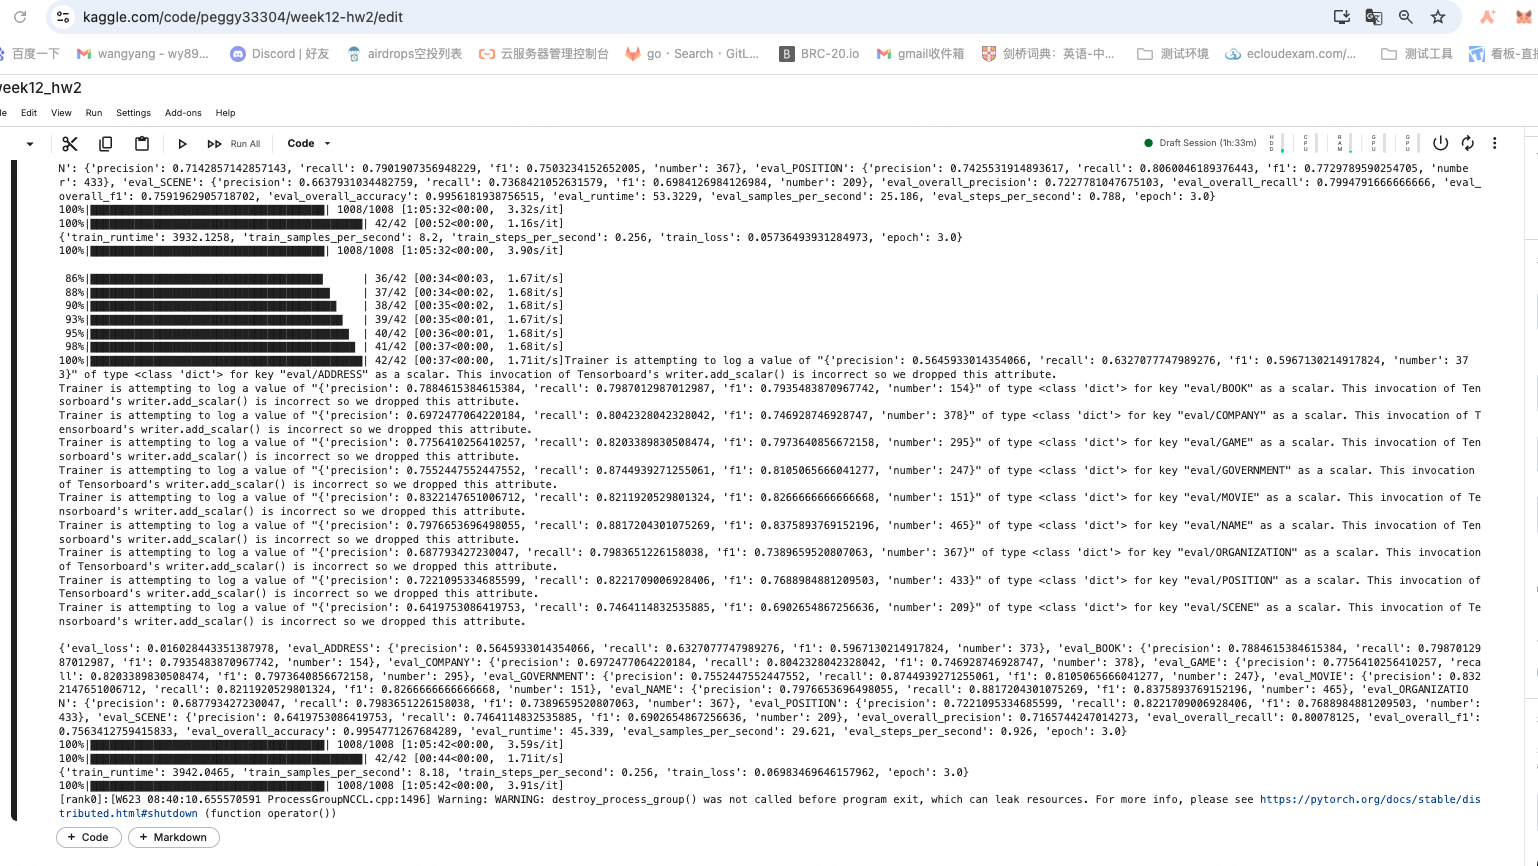

## 模型推理

In [ ]:
from transformers import pipeline


pipeline = pipeline('token-classification', 'ner_train/checkpoint-1000')

In [ ]:
pipeline('新浪网新闻中心是新浪网最重要的频道之一,24小时滚动报道国内、国际及社会新闻。每日编发新闻数以万计。')

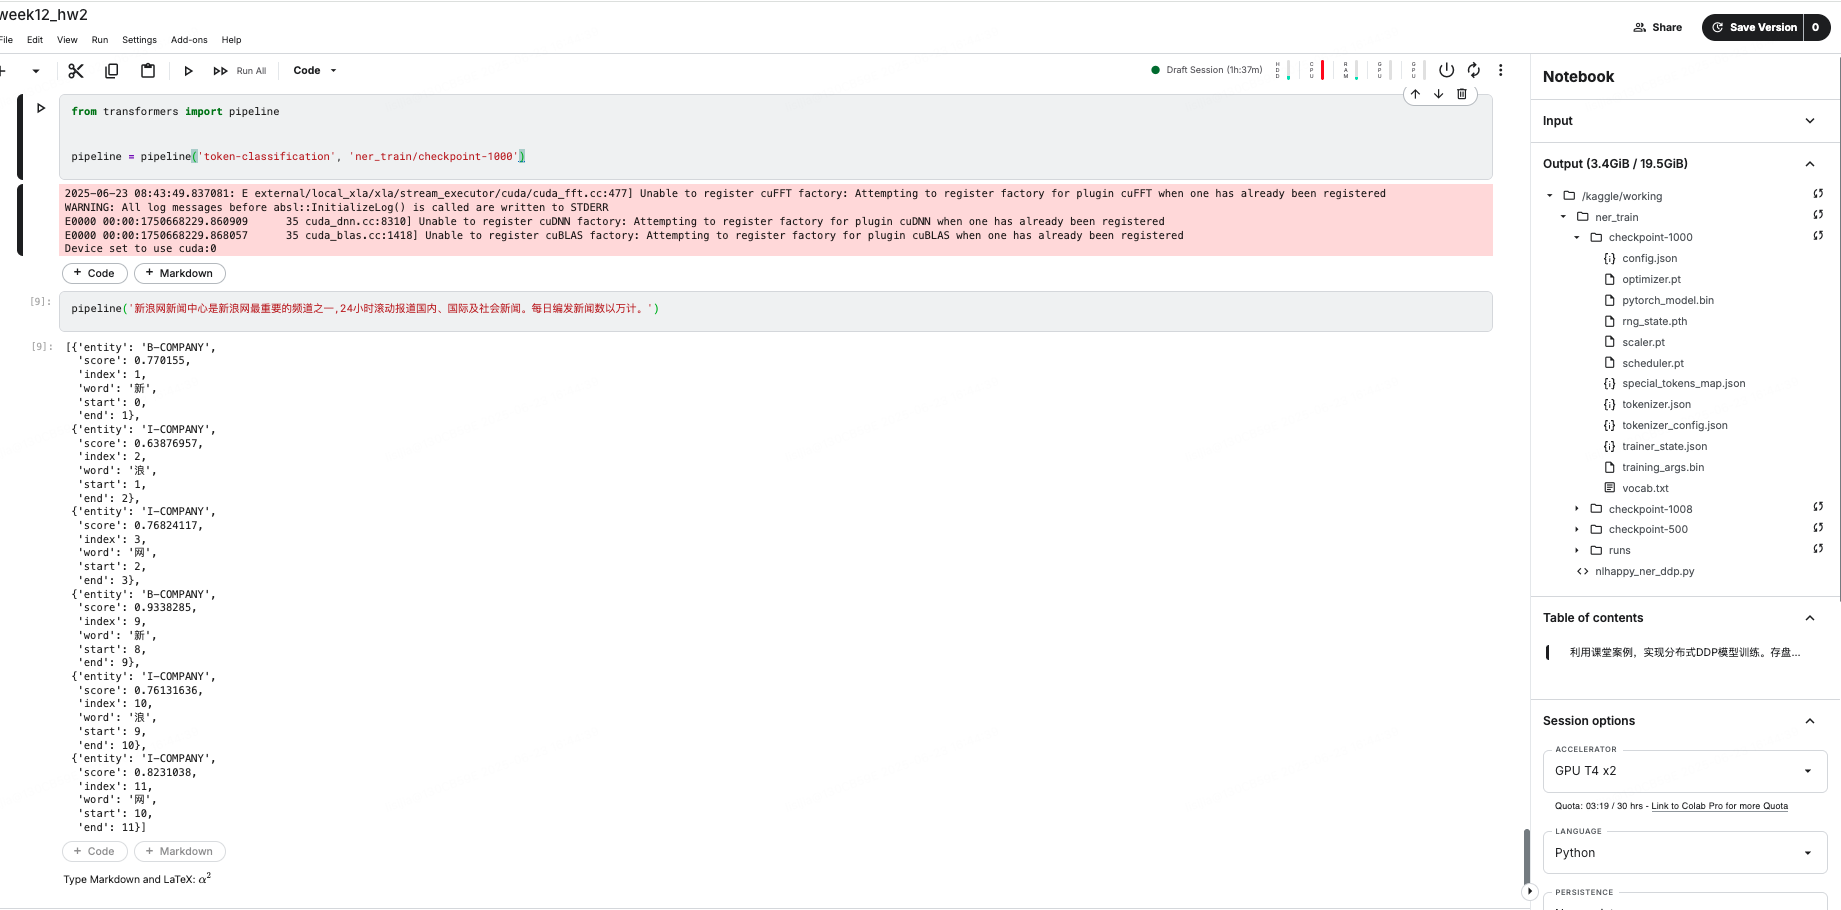